In [41]:
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
import numpy as np
import unittest

In [42]:
from math import gamma
# Util functions

def gaussian_distribution_density_data(mu, sigma):
    """
        Given a mu and a sigma, this function returns a tuple representing the X and Y of the PDF

        params: mu, sigma <numbers>
        return: X, Y of the normal distribution()
    """
    data = torch.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
    gaussian_distribution = (1/(sigma * torch.sqrt(torch.tensor(2) * torch.pi))) * torch.exp(-0.5 * ((data - mu) / sigma)**2)
    return data, gaussian_distribution

def plot(X, mu1, sigma1, mu2, sigma2, title=''):
    # a) Scatter Plot with histograms
    # Histograms
    plt.hist(X, bins=50, alpha=0.25, density = True, histtype='bar', ec='black')
    # Scatter
    plt.scatter(X,torch.zeros(len(X)))
    # Density
    x1, gaussian_density_1 = gaussian_distribution_density_data(mu1, sigma1)
    x2, gaussian_density_2 = gaussian_distribution_density_data(mu2, sigma2)
    plt.plot(x1, gaussian_density_1, label=f'Gaussian (mu={mu1}, sigma={sigma1})', color='red')
    plt.plot(x2, gaussian_density_2, label=f'Gaussian (mu={mu2}, sigma={sigma2})', color='blue')
    if len(title):
        plt.title(title)
    plt.legend()
    plt.show()

# Trabajo Práctico 0: Algoritmo de Maximización de la Esperanza

X =  tensor([ 9.9760,  9.3734, 10.0540, 13.1105,  9.9009, 10.8469,  4.2807,  7.0942,
         6.6829,  6.3952, 12.2361,  8.5334, 11.1347,  4.2374, 13.2530,  0.8863,
         7.5987,  8.7360, 10.0478,  9.0564, 31.8202, 29.0509, 29.7558, 29.0856,
        31.2543, 31.7308, 31.3326, 29.0952, 27.0672, 34.2254, 25.5188, 30.7234,
        28.7222, 28.2966, 30.3916, 28.1267, 31.4325, 30.5106, 30.7818, 29.8589])


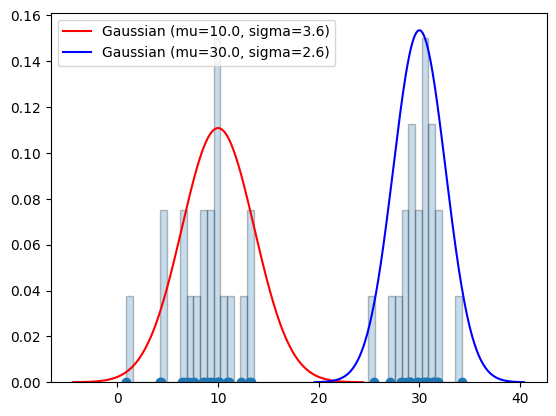

In [43]:
n = 20
mu1 = 10.0
sigma1 = 3.6
mu2 = 30.0
sigma2 = 2.6

# 1)
# Generates data that follows two 2gaussian distributions based on a set of parameters.
def generate_data(n, mu1, sigma1, mu2, sigma2):

  # Generate distributions
  normal_dist1 = torch.distributions.Normal(torch.tensor([mu1]), torch.tensor([sigma1]))
  normal_dist2 = torch.distributions.Normal(torch.tensor([mu2]), torch.tensor([sigma2]))

  # Take a sample from each dist
  gaussian_sample1 = normal_dist1.sample((n,1)).squeeze()
  gaussian_sample2 = normal_dist2.sample((n,1)).squeeze()

  # Concatenate the 2 samples
  X =  torch.cat((gaussian_sample1, gaussian_sample2))
  return X

X = generate_data(n, mu1, sigma1, mu2, sigma2)
print('X = ', X)

plot(X, mu1, sigma1, mu2, sigma2)



In [44]:
# 2)
def init_random_parameters(k=2, range=50):
  """
      Generates randombly mu and sigma parameters
      params: k, range
      return: A Kx2 matrix where colum 0 corresponds to mu and column 1 to sigma
  """
  return torch.rand((k, 2))*range

P = init_random_parameters()
print('P = ', P)

P =  tensor([[35.5887, 32.5672],
        [40.9779,  2.8171]])


In [45]:
# 3)
def calculate_log_likelihood_gaussian_observation(x_n, mu_k, sigma_k):
  # Nota: tal vez deberíamos poner en el latex el proceso desde la función de likelihood sin log hasta esta versión
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)

likelihood_test = calculate_log_likelihood_gaussian_observation(X[0], mu1, sigma1)
print('likelihood_test = ', likelihood_test)

class LikelihoodGuassianUnitTest(unittest.TestCase):

    def test_likelihood_lower_real(self):
      test_data = torch.distributions.Normal(torch.tensor([4.0]), torch.tensor([8.0]))
      test_gaussian_sample = torch.tensor(test_data.sample((30,1)).squeeze())

      real_lgo = calculate_log_likelihood_gaussian_observation(test_gaussian_sample, 4.0, 8.0)
      false_lgo = calculate_log_likelihood_gaussian_observation(test_gaussian_sample, 40.0, 7.0)
      self.assertTrue(abs(real_lgo) < abs(false_lgo))

    def test_likelihood_value(self):
      test_gaussian_sample = torch.tensor([0.34, 0.45, 0.78])
      likelihood = calculate_log_likelihood_gaussian_observation(test_gaussian_sample, 4.0, 8.0)
      self.assertAlmostEquals(float(likelihood), -3.2824, 3)

unittest.main(argv=[''], verbosity=2, exit=False)

test_likelihood_lower_real (__main__.LikelihoodGuassianUnitTest) ... <ipython-input-45-5ded7ba2f913>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_gaussian_sample = torch.tensor(test_data.sample((30,1)).squeeze())
ok
test_likelihood_value (__main__.LikelihoodGuassianUnitTest) ... <ipython-input-45-5ded7ba2f913>:22: DeprecationWarning: Please use assertAlmostEqual instead.
  self.assertAlmostEquals(float(likelihood), -3.2824, 3)
ok

----------------------------------------------------------------------
Ran 2 tests in 0.014s

OK


likelihood_test =  tensor(-2.1999)


In [46]:
# 4)
def calculate_membership_dataset(X_dataset, Parameters_matrix, k=2):
  N = len(X_dataset)
  #print(N)
  M = torch.zeros(N, k)

  # for each element in X, calculate its likelyhood with each set of parameters from the Parameter Matrix and store the maximum
  for x in range(N):
    # set max likelyhood initially as a very low number (Me suena que esto también podría ponerse de una mejor forma)
    x_max_likelyhood = -999999999
    k_membership = 0
    # iterate over the parameter sets to find which set achieves max likelihood over x
    for k_index, parameters in enumerate(Parameters_matrix):
      #print('Debug: x = ', X_dataset[x], 'params = ', parameters[0], parameters[1])
      x_likelyhood = calculate_log_likelihood_gaussian_observation(X_dataset[x], parameters[0], parameters[1])
      #print('Debug: x_likelyhood = ', x_likelyhood)
      if x_likelyhood > x_max_likelyhood:
        x_max_likelyhood = x_likelyhood
        #print('Debug: max likelyhood = ', x_max_likelyhood)
        k_membership = k_index
    M[x][k_membership] = 1

  return M

M = calculate_membership_dataset(X, P)
print('M = ', M)

M =  tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])


<ipython-input-45-5ded7ba2f913>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)


In [47]:
#5)

def recalculate_parameters(X_dataset, Membership_data):
    # TODO: Can we improve this to use torch?
    membership_k1 = Membership_data[:,0]
    membership_k2 = Membership_data[:,1]
    k1_tentative_values = torch.tensor([x for index, x in enumerate(X_dataset) if membership_k1[index] == 1])
    k2_tentative_values = torch.tensor([x for index, x in enumerate(X_dataset) if membership_k2[index] == 1])
    mu_1 = torch.mean(k1_tentative_values)
    mu_2 = torch.mean(k2_tentative_values)
    sigma_1 = torch.std(k1_tentative_values)
    sigma_2 = torch.std(k2_tentative_values)
    return torch.tensor([[mu_1, sigma_1],[mu_2, sigma_2]])

print('Real parameters k1=[{},{}], k2=[{},{}] '.format(mu1, sigma1, mu2, sigma2))
print('Old P parameters: ', P)
P = recalculate_parameters(X, M)
print('New P parameters: ', P)

Real parameters k1=[10.0,3.6], k2=[30.0,2.6] 
Old P parameters:  tensor([[35.5887, 32.5672],
        [40.9779,  2.8171]])
New P parameters:  tensor([[19.3054, 11.0681],
        [    nan,     nan]])


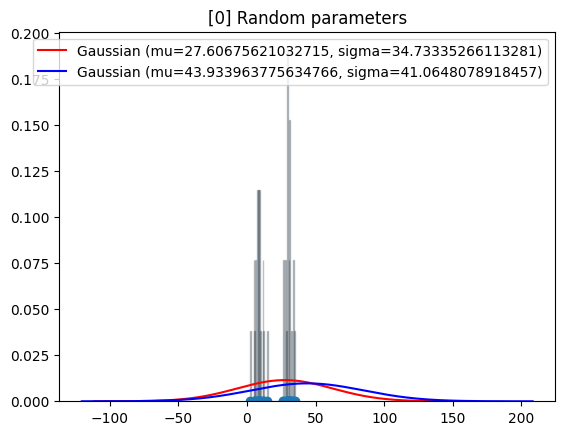

<ipython-input-45-5ded7ba2f913>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)


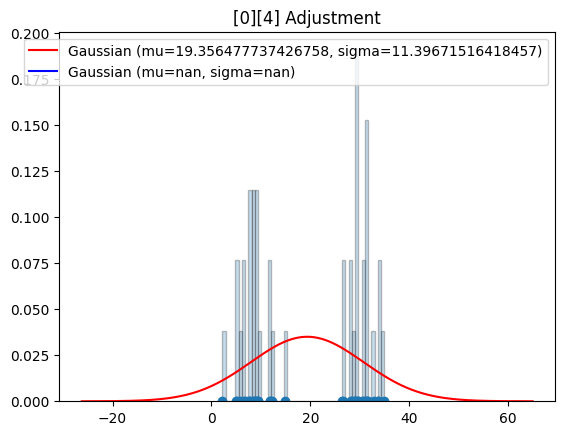

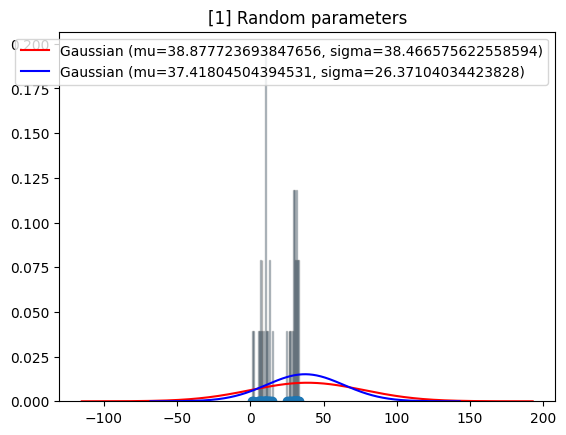

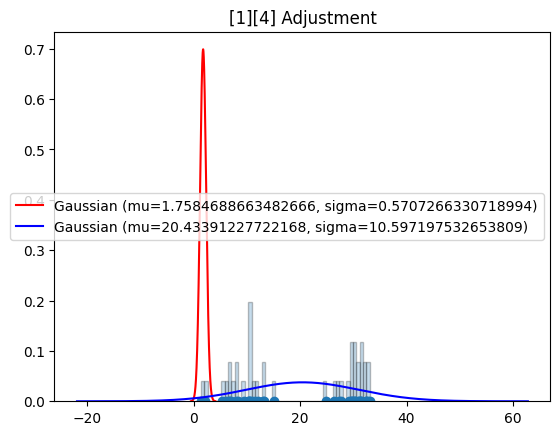

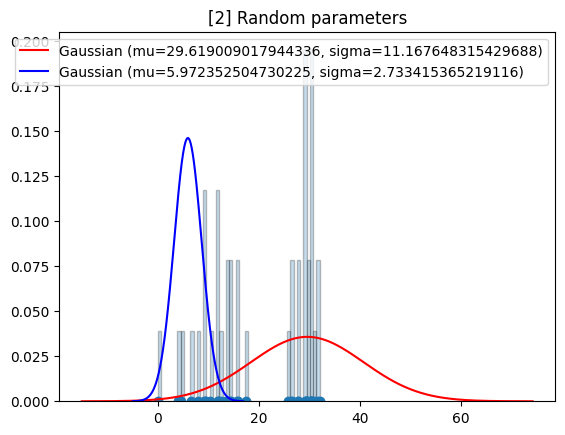

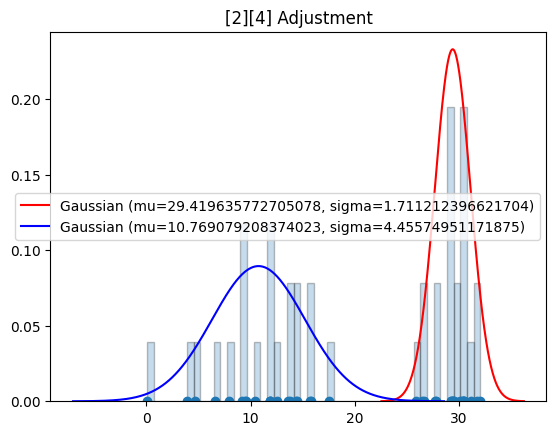

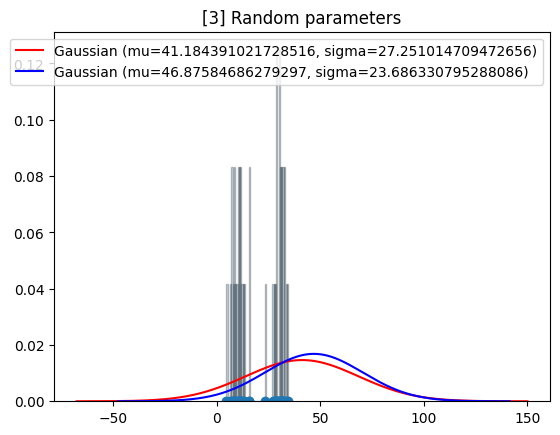

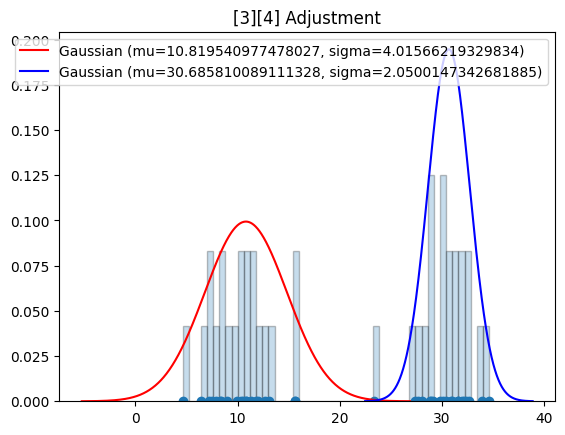

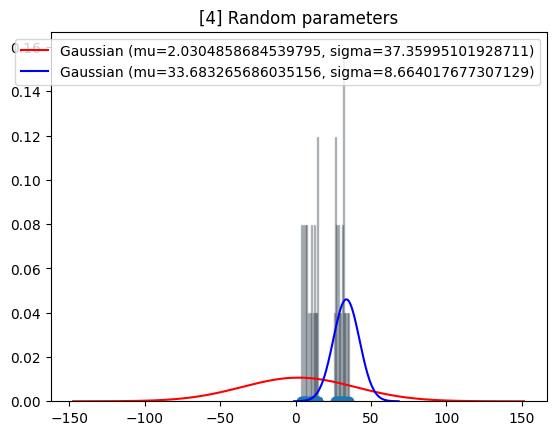

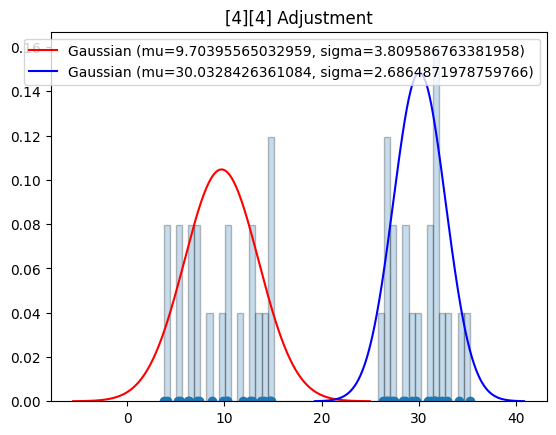

In [48]:
i_max = 5
i_adj_max = 5

mu1 = 10.0
sigma1 = 3.6
mu2 = 30.0
sigma2 = 2.6

for i in range(i_max):
    X = generate_data(n, mu1, sigma1, mu2, sigma2)
    P = init_random_parameters()
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}] Random parameters'.format(i))

    for a in range(i_adj_max):
        M = calculate_membership_dataset(X, P)

        #print('[', i,'] Old P parameters: ', P)
        P = recalculate_parameters(X, M)
        #print('[', i,'] New P parameters: ', P, '\n')
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}][{}] Adjustment'.format(i, a))

In [49]:
# 7)
def random_parameters_heuristic(X):
    mu = torch.mean(X, dim=0)
    sigma = torch.std(X, dim=0)
    mu_below = mu - sigma
    mu_above = mu + sigma
    mu1 = (mu - mu_below) * torch.rand(1) + mu_below
    sigma1 = (sigma / 2 - sigma / 4) * torch.rand(1) + sigma / 4
    mu2 = (mu_above - mu) * torch.rand(1) + mu
    sigma2 = (sigma / 2 - sigma / 4) * torch.rand(1) + sigma / 4
    return torch.tensor([[mu1, sigma1], [mu2, sigma2]])



PI = random_parameters_heuristic(X)
print(PI)

tensor([[18.0583,  3.1854],
        [27.4731,  4.4862]])


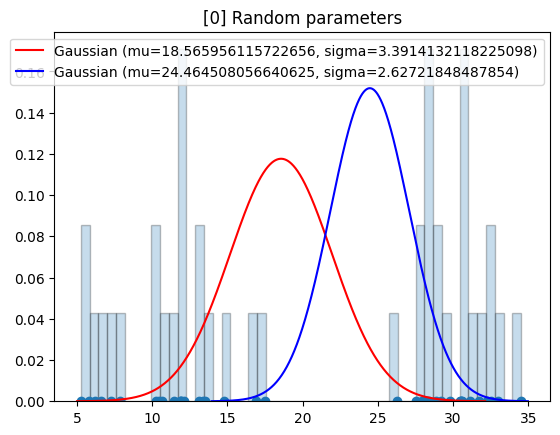

<ipython-input-45-5ded7ba2f913>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)


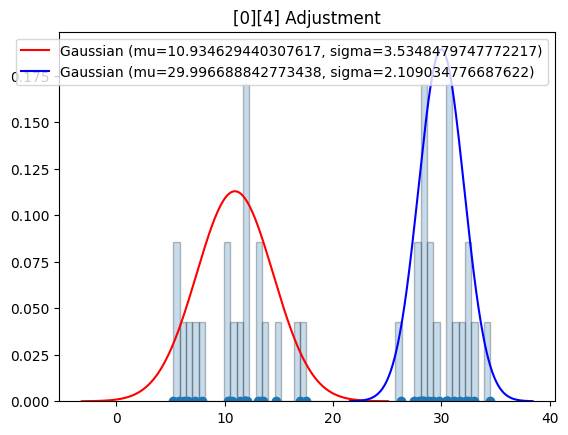

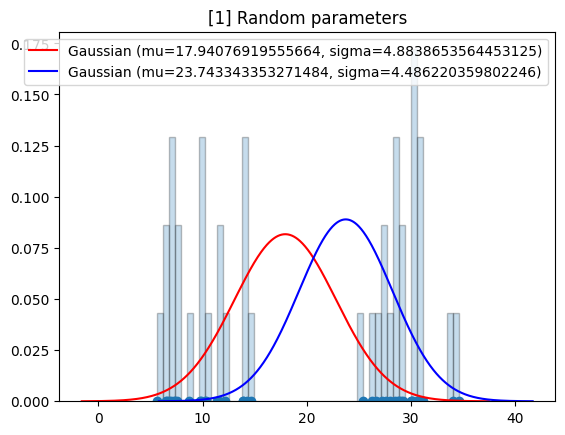

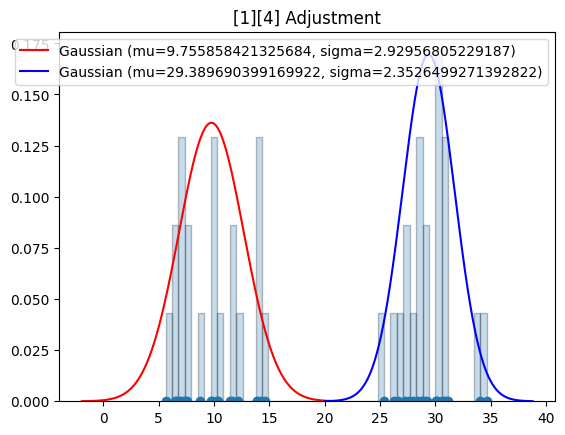

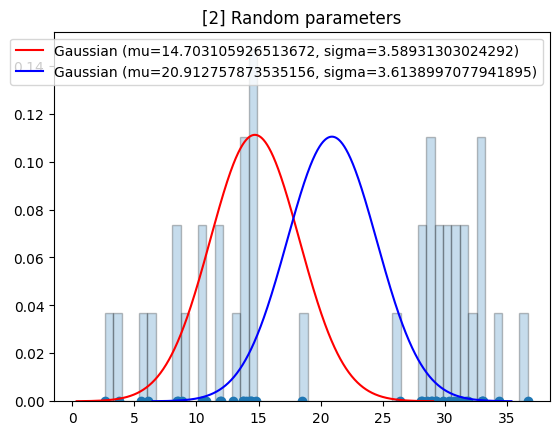

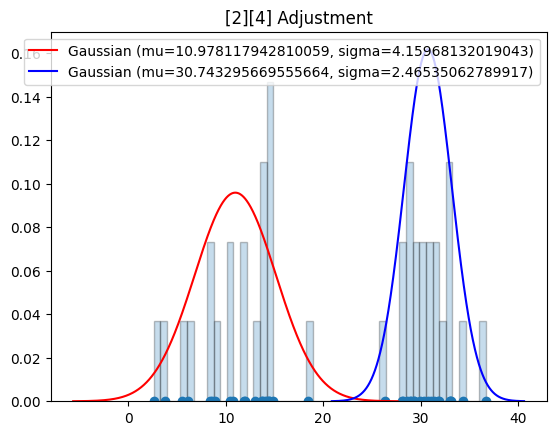

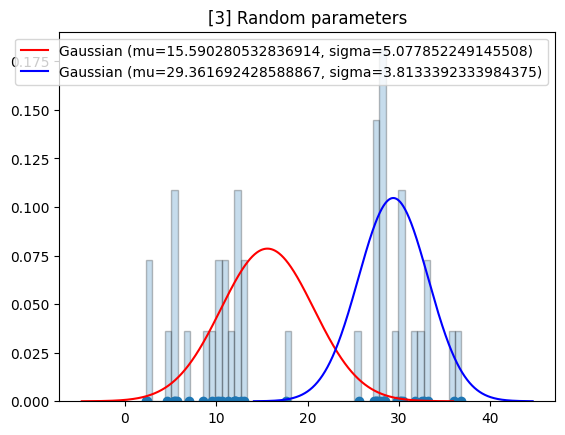

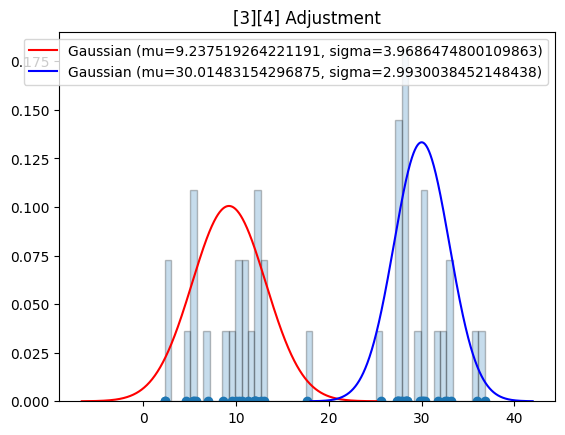

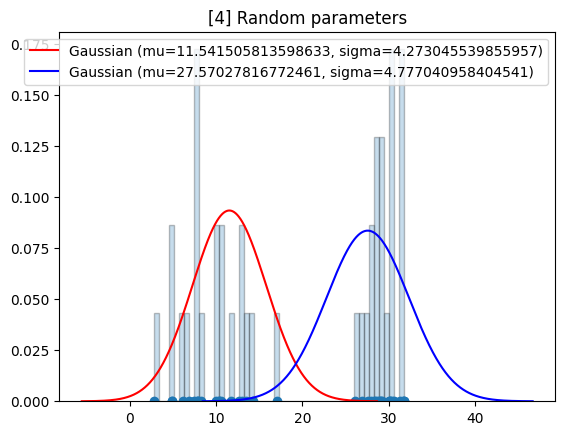

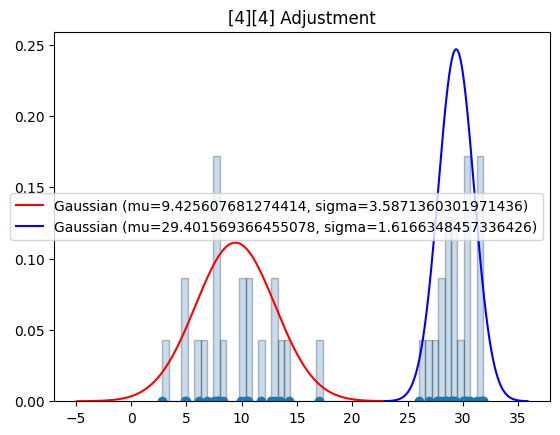

In [50]:
i_max = 5
i_adj_max = 5

mu1 = 10.0
sigma1 = 3.6
mu2 = 30.0
sigma2 = 2.6

for i in range(i_max):
    X = generate_data(n, mu1, sigma1, mu2, sigma2)
    P = random_parameters_heuristic(X)
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}] Random parameters'.format(i))

    for a in range(i_adj_max):
        M = calculate_membership_dataset(X, P)

        #print('[', i,'] Old P parameters: ', P)
        P = recalculate_parameters(X, M)
        #print('[', i,'] New P parameters: ', P, '\n')
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}][{}] Adjustment'.format(i, a))

#Algoritmo de Maximización de la Esperanza con datos artificiales (modelo Gamma)

In [51]:
# Util funcitons

def gamma_distribution_density_data(k, theta):
    """
        Given a k and a theta, this function returns a tuple representing the X and Y of the PDF

        params: k, theta <numbers>
        return: X, Y of the gamma distribution()
    """
    data = torch.linspace(k - 4*theta, k + 4*theta, 1000)

    gamma_distribution = ( (1/(gamma(k)*(theta**k))) * (data**(k-1)) * (torch.exp(-1 * data/theta)) )

    return data, gamma_distribution

def plot_gamma(X, k1, theta1, k2, theta2, title=''):
    # a) Scatter Plot with histograms
    # Histograms
    plt.hist(X, bins=50, alpha=0.25, density = True, histtype='bar', ec='black')
    # Scatter
    plt.scatter(X,torch.zeros(len(X)))
    # Density
    x1, gamma_density_1 = gamma_distribution_density_data(k1, theta1)
    #print('DEBUG: gamma_density_1', gamma_density_1)
    x2, gamma_density_2 = gamma_distribution_density_data(theta2, theta2)
    #print(gamma_distribution_density_data(alpha2, beta2))
    plt.plot(x1, gamma_density_1, label=f'Gamma (k={k1}, theta={theta1})', color='red')
    plt.plot(x2, gamma_density_2, label=f'Gamma (k={k2}, theta={theta2})', color='blue')
    plt.ylim(0, 2)
    plt.xlim(0,torch.max(X))
    #plt.plot.ylim = (0, 0.3)
    if len(title):
        plt.title(title)
    plt.legend()
    plt.show()

X =  tensor([0.0095, 0.0651, 0.0025, 0.1279, 0.0346, 0.0112, 0.8395, 0.1410, 0.0568,
        0.1105, 0.2012, 1.1273, 0.0149, 0.1324, 0.0168, 0.3744, 0.0125, 0.4018,
        0.4970, 0.0037, 0.3460, 0.2650, 0.2575, 0.5037, 0.5330, 0.2752, 0.1203,
        0.1162, 0.5516, 0.5578, 0.1797, 0.8921, 0.1894, 0.5126, 0.2917, 0.4246,
        0.3742, 0.3021, 0.5356, 0.0751])


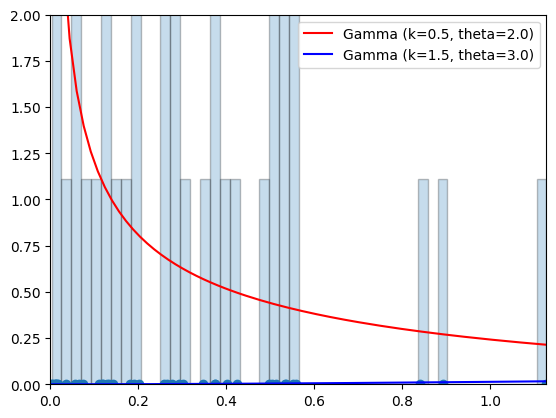

In [52]:
# 2)
k1 = .5
theta1 = 2.0
k2 = 1.5
theta2 = 3.0
# Generates data that follows two gamma distributions based on a set of parameters.
# parameters:
#    * k: shape
#    * theta:  scale
def generate_gamma_data(n, k1, theta1, k2, theta2):

  # Generate distributions
  gamma_dist1 = torch.distributions.Gamma(torch.tensor([k1]), torch.tensor([theta1]))
  gamma_dist2 = torch.distributions.Gamma(torch.tensor([k2]), torch.tensor([theta2]))

  # Take a sample from each dist
  gamma_sample1 = gamma_dist1.sample((n,1)).squeeze()
  gamma_sample2 = gamma_dist2.sample((n,1)).squeeze()

  # Concatenate the 2 samples
  X =  torch.cat((gamma_sample1, gamma_sample2))
  return X

X = generate_gamma_data(n, k1, theta1, k2, theta2)
print('X = ', X)

plot_gamma(X, k1, theta1, k2, theta2)


In [53]:
def calculate_likelihood_gamma_observation(x_n, alpha_k, beta_k):
    """
        Given an alpha, a beta, and an x observation this function returns the
        likelyhood that said x belongs to the gamma distribution that results
        from that alpha and beta.

        params: alpha, beta, x <numbers>
        return: likelyhood
    """
    # Non logarithmic gamma distribution.
    if x_n > 0:
      a = 1/((beta_k**alpha_k)*gamma(alpha_k))
      b = x_n**(alpha_k-1)
      c = torch.exp(-1 * x_n/beta_k)
      likelyhood = a * b * c
    else:
      likelyhood = 0

    return likelyhood

def calculate_log_likelihood_gamma_observation(x_n, alpha_k, beta_k):
    """
        Given an alpha, a beta, and an x observation this function returns the
        logarithmic likelyhood that said x belongs to the gamma distribution
        that results from that alpha and beta.

        params: alpha, beta, x <numbers>
        return: likelyhood
    """
    # logarithmic gamma distribution.
    #if x_n > 0:
    a = -1*(alpha_k*torch.log(beta_k))
    b = -1*torch.log(torch.tensor(gamma(alpha_k)))
    c = torch.sum( (alpha_k - 1) * torch.log(x_n) - (x_n/beta_k) )
    likelihood = a + b + c
    #else:
      #likelihood = 0

    return likelihood

def calculate_log_likelihood_gamma_observation_2(x_n, alpha_k, beta_k):
    """
        Given an alpha, a beta, and an x observation this function returns the
        logarithmic likelyhood that said x belongs to the gamma distribution
        that results from that alpha and beta.

        params: alpha, beta, x <numbers>
        return: likelyhood
    """
    # logarithmic gamma distribution.
    #if x_n > 0:
    a = alpha_k*torch.log(beta_k)
    b = -1*(x_n)
    c = (alpha_k - 1) * torch.log(x_n)
    d = -1*torch.log(torch.tensor(gamma(alpha_k)))

    likelihood = a + b + c + d
    #else:
      #likelihood = 0

    return likelihood

In [54]:
# 2)
def init_random_parameters(k=2, range=5):
  """
      Generates randombly mu and sigma parameters
      params: k, range
      return: A Kx2 matrix where colum 0 corresponds to mu and column 1 to sigma
  """
  return torch.rand((k, 2))*range

P = init_random_parameters()
print('P = ', P)

def calculate_membership_dataset_gamma(X_dataset, Parameters_matrix, k=2):
  N = len(X_dataset)
  #print(N)
  M = torch.zeros(N, k)

  # for each element in X, calculate its likelyhood with each set of parameters from the Parameter Matrix and store the maximum
  for x in range(N):
    # set max likelyhood initially as a very low number (Me suena que esto también podría ponerse de una mejor forma)
    x_max_likelyhood = -999999999
    k_membership = 0
    # iterate over the parameter sets to find which set achieves max likelihood over x
    for k_index, parameters in enumerate(Parameters_matrix):
      #print('Debug: x = ', X_dataset[x], 'params = ', parameters[0], parameters[1])
      x_likelyhood = calculate_log_likelihood_gamma_observation_2(X_dataset[x], parameters[0], parameters[1])
      #print('Debug: x_likelyhood = ', x_likelyhood)
      if x_likelyhood > x_max_likelyhood:
        x_max_likelyhood = x_likelyhood
        #print('Debug: max likelyhood = ', x_max_likelyhood)
        k_membership = k_index
    M[x][k_membership] = 1

  return M

M = calculate_membership_dataset(X, P)
print('M = ', M)

P =  tensor([[2.8718, 4.4054],
        [1.3042, 3.5510]])
M =  tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])


<ipython-input-45-5ded7ba2f913>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)


In [59]:
def recalculate_parameters(X_dataset, Membership_data):
    # TODO: Can we improve this to use torch?
    membership_k1 = Membership_data[:,0]
    membership_k2 = Membership_data[:,1]
    k1_tentative_values = torch.tensor([x for index, x in enumerate(X_dataset) if membership_k1[index] == 1])
    k2_tentative_values = torch.tensor([x for index, x in enumerate(X_dataset) if membership_k2[index] == 1])
    print(k1_tentative_values)
    k_1 = torch.mean(k1_tentative_values)**2 / torch.var(k1_tentative_values)
    k_2 = torch.mean(k2_tentative_values)**2 / torch.var(k2_tentative_values)
    theta_1 = torch.var(k1_tentative_values)/ torch.mean(k1_tentative_values)
    theta_2 = torch.var(k2_tentative_values)/ torch.mean(k2_tentative_values)
    return torch.tensor([[k_1, theta_1],[k_2, theta_2]])

print('Real parameters k1=[{},{}], k2=[{},{}] '.format(k1, theta1, k2, theta2))
print('Old P parameters: ', P)
P = recalculate_parameters(X, M)
print('New P parameters: ', P)

Real parameters k1=[0.5,2.0], k2=[1.5,3.0] 
Old P parameters:  tensor([[ 1.8445, -1.2401],
        [ 1.8047,  1.1736]])
tensor([-1.5715, -0.2890, -1.1569, -5.3186, -4.9160, -1.5432, -2.2269, -0.6076,
        -1.0364, -3.8332, -3.4545, -1.4957])
New P parameters:  tensor([[ 1.8445, -1.2401],
        [ 1.8047,  1.1736]])


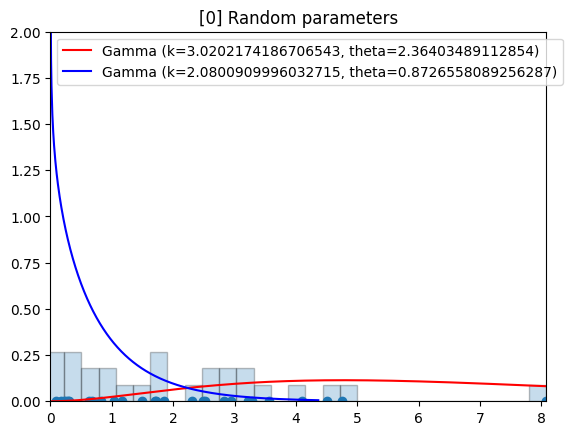

tensor([ 0.2220,  1.7005,  2.8259, -2.1836, -1.1797, -1.7280,  0.1738,  0.2919,
         3.2812, -2.5497,  2.5150,  0.8300,  1.0316, -3.4336,  0.6788,  1.1695,
        -0.8197, -2.3147,  2.9379,  2.3057,  4.5012,  2.4885,  0.2948, -2.0584,
        -1.0868, -0.3836,  3.2159,  4.7478, -5.9536,  3.5549,  1.7132,  8.0819,
         4.0952,  0.6321,  0.2519, -0.2639,  1.8565,  1.4917, -0.8725])
tensor([ 0.2220,  1.7005,  2.8259, -2.1836, -1.1797, -1.7280,  0.1738,  0.2919,
         3.2812, -2.5497,  2.5150,  0.8300,  1.0316, -3.4336,  0.6788,  0.0912,
         1.1695, -0.8197, -2.3147,  2.9379,  2.3057,  4.5012,  2.4885,  0.2948,
        -2.0584, -1.0868, -0.3836,  3.2159,  4.7478, -5.9536,  3.5549,  1.7132,
         8.0819,  4.0952,  0.6321,  0.2519, -0.2639,  1.8565,  1.4917, -0.8725])
tensor([ 0.2220,  1.7005,  2.8259, -2.1836, -1.1797, -1.7280,  0.1738,  0.2919,
         3.2812, -2.5497,  2.5150,  0.8300,  1.0316, -3.4336,  0.6788,  0.0912,
         1.1695, -0.8197, -2.3147,  2.9379,  2.

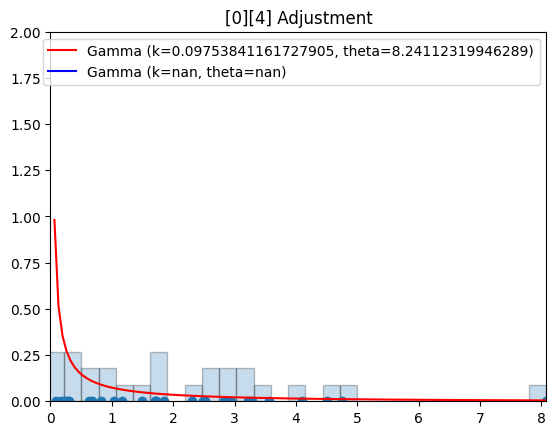

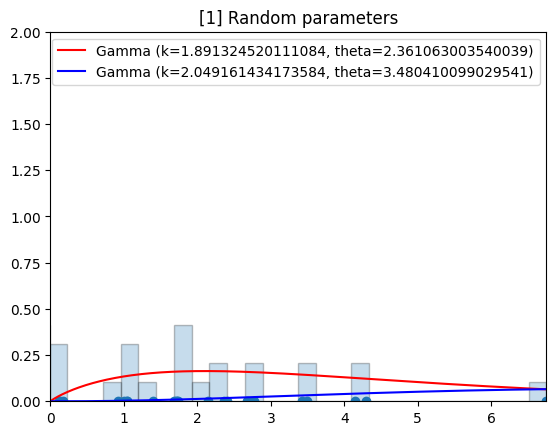

tensor([-0.1369, -1.2050, -1.3811, -0.0717, -1.1006, -0.1283, -2.0459, -2.1746,
        -2.5847, -0.6401, -3.6833, -2.3307, -2.6793, -0.7916, -0.1151, -0.6303,
        -3.0057, -5.3238])
tensor([-0.1369, -1.2050, -1.3811, -0.0717, -1.1006, -0.1283, -2.0459, -2.1746,
        -2.5847, -0.6401, -3.6833, -2.3307, -2.6793, -0.7916, -0.1151, -0.6303,
        -3.0057, -5.3238])
tensor([-0.1369, -1.2050, -1.3811, -0.0717, -1.1006, -0.1283, -2.0459, -2.1746,
        -2.5847, -0.6401, -3.6833, -2.3307, -2.6793, -0.7916, -0.1151, -0.6303,
        -3.0057, -5.3238])
tensor([-0.1369, -1.2050, -1.3811, -0.0717, -1.1006, -0.1283, -2.0459, -2.1746,
        -2.5847, -0.6401, -3.6833, -2.3307, -2.6793, -0.7916, -0.1151, -0.6303,
        -3.0057, -5.3238])
tensor([-0.1369, -1.2050, -1.3811, -0.0717, -1.1006, -0.1283, -2.0459, -2.1746,
        -2.5847, -0.6401, -3.6833, -2.3307, -2.6793, -0.7916, -0.1151, -0.6303,
        -3.0057, -5.3238])


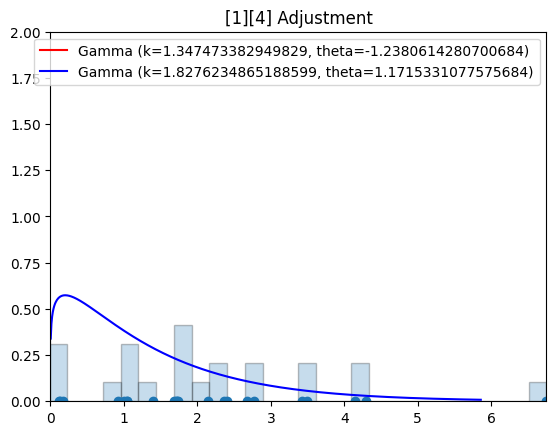

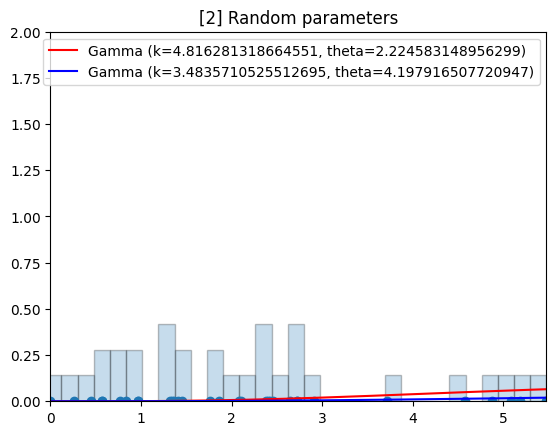

tensor([-1.5052e+00, -9.3893e-01, -1.2730e+00, -4.2742e-04, -3.4502e+00,
        -2.3527e-01, -1.0176e+00, -1.2768e-01, -2.3410e+00])
tensor([-1.5052e+00, -9.3893e-01, -1.2730e+00, -4.2742e-04, -3.4502e+00,
        -2.3527e-01, -1.0176e+00, -1.2768e-01, -2.3410e+00])
tensor([-1.5052e+00, -9.3893e-01, -1.2730e+00, -4.2742e-04, -3.4502e+00,
        -2.3527e-01, -1.0176e+00, -1.2768e-01, -2.3410e+00])
tensor([-1.5052e+00, -9.3893e-01, -1.2730e+00, -4.2742e-04, -3.4502e+00,
        -2.3527e-01, -1.0176e+00, -1.2768e-01, -2.3410e+00])
tensor([-1.5052e+00, -9.3893e-01, -1.2730e+00, -4.2742e-04, -3.4502e+00,
        -2.3527e-01, -1.0176e+00, -1.2768e-01, -2.3410e+00])


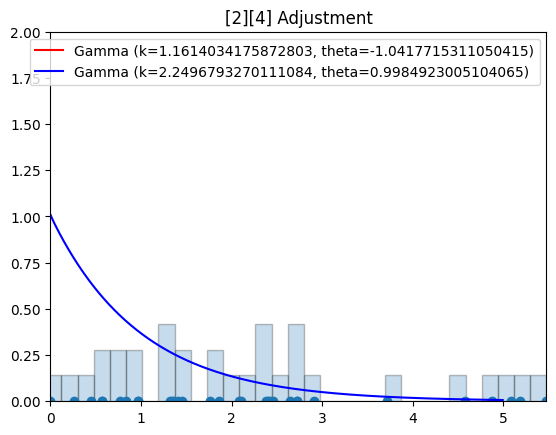

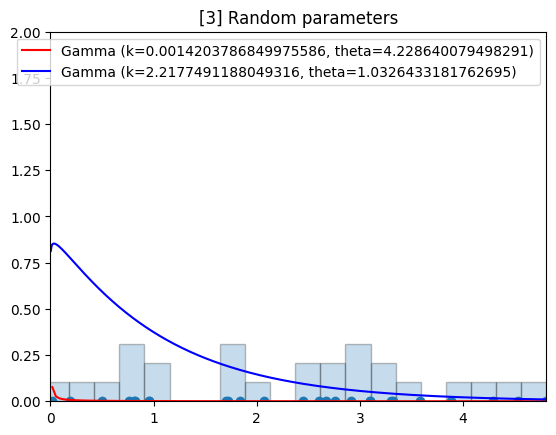

tensor([-3.7232, -1.3612, -0.4154, -1.5293, -0.1288, -1.8867, -1.5574, -5.8492,
        -1.8479, -2.2224, -7.3729, -0.6934, -0.6353, -1.0218,  0.0101])
tensor([-3.7232, -1.3612, -0.4154, -1.5293, -0.1288, -1.8867, -1.5574, -5.8492,
        -1.8479, -2.2224, -7.3729, -0.6934, -0.6353, -1.0218])
tensor([-3.7232, -1.3612, -0.4154, -1.5293, -0.1288, -1.8867, -1.5574, -5.8492,
        -1.8479, -2.2224, -7.3729, -0.6934, -0.6353, -1.0218])
tensor([-3.7232, -1.3612, -0.4154, -1.5293, -0.1288, -1.8867, -1.5574, -5.8492,
        -1.8479, -2.2224, -7.3729, -0.6934, -0.6353, -1.0218])
tensor([-3.7232, -1.3612, -0.4154, -1.5293, -0.1288, -1.8867, -1.5574, -5.8492,
        -1.8479, -2.2224, -7.3729, -0.6934, -0.6353, -1.0218])


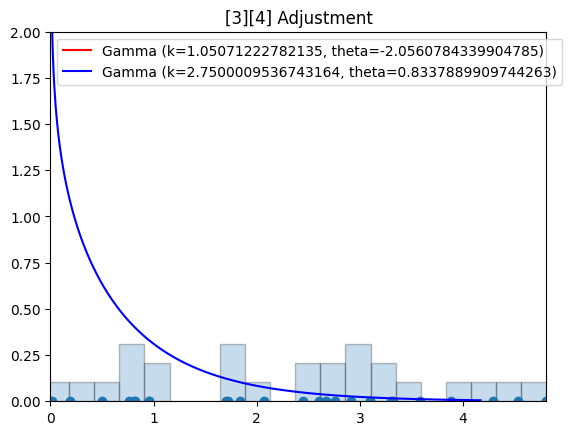

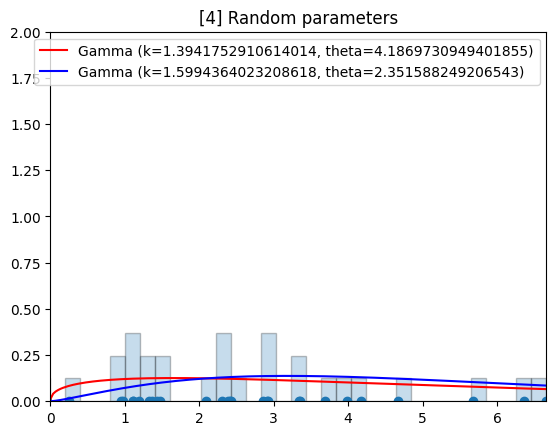

tensor([ 2.0915,  2.4223, -2.5427,  2.3843, -0.3223,  1.1915, -1.4584, -2.3192,
         1.1080,  3.9869,  0.9414,  3.3377, -1.5592,  2.3032,  2.9107,  0.2427,
         3.6893, -2.0108,  1.4680, -0.7347,  1.1153,  4.6651, -0.0434, -3.4397,
        -2.0178,  6.6651,  6.3638,  2.8601,  1.3700, -1.2791, -0.2836,  5.6832,
         1.3235,  1.4364,  4.1678, -1.4353,  2.9190,  0.9800,  3.3550,  2.4154])
tensor([ 2.0915,  2.4223, -2.5427,  2.3843, -0.3223,  1.1915, -1.4584, -2.3192,
         1.1080,  3.9869,  0.9414,  3.3377, -1.5592,  2.3032,  2.9107,  0.2427,
         3.6893, -2.0108,  1.4680, -0.7347,  1.1153,  4.6651, -0.0434, -3.4397,
        -2.0178,  6.6651,  6.3638,  2.8601,  1.3700, -1.2791, -0.2836,  5.6832,
         1.3235,  1.4364,  4.1678, -1.4353,  2.9190,  0.9800,  3.3550,  2.4154])
tensor([ 2.0915,  2.4223, -2.5427,  2.3843, -0.3223,  1.1915, -1.4584, -2.3192,
         1.1080,  3.9869,  0.9414,  3.3377, -1.5592,  2.3032,  2.9107,  0.2427,
         3.6893, -2.0108,  1.4680, -0.

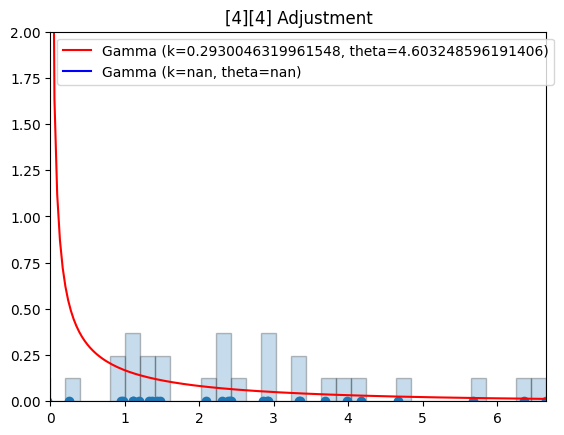

In [60]:
for i in range(i_max):
    X = generate_data(n, k1, theta1, k2, theta2)
    #P = random_parameters_heuristic(X)
    P = init_random_parameters()
    plot_gamma(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}] Random parameters'.format(i))

    for a in range(i_adj_max):
        M = calculate_membership_dataset_gamma(X, P)

        #print('[', i,'] Old P parameters: ', P)
        P = recalculate_parameters(X, M)
        #print('[', i,'] New P parameters: ', P, '\n')
    plot_gamma(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}][{}] Adjustment'.format(i, a))